# IbPRIA 2025 - Data-Efficient Strategies for Object Detection

> 📌 **Note**: You can run this notebook on:
>
> - 💻 Your local machine (Python ≥ 3.8, see `requirements.txt`)
> - 🌐 [Google Colab](https://colab.research.google.com/github/dinisdcosta/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/blob/main/old.ipynb)



## Annotation Guidelines for Object Detection



In object detection tasks, each image must be labeled with **bounding boxes** that enclose every object the model is expected to detect. For each bounding box, a corresponding **class label** must be assigned.

There are several tools available for this annotation process:

- If you're working with a **small dataset** and need a lightweight solution, we recommend [labelImg](https://pypi.org/project/labelImg/).
- For **larger projects** with multiple annotators, we suggest using a more robust platform such as [Label Studio](https://labelstud.io/), which provide better support for collaboration.

### Bounding Box Best Practices

A bounding box is defined by its **center coordinates**, **width**, and **height**. For accurate annotations:

- The **center of the bounding box** should align with the center of the corresponding object.
- The edges of the bounding box should **not exceed the boundaries** of the object.
- Boxes should be **tight** but not overly precise — enough to capture the object clearly without including background noise.

> Ensuring consistent and accurate annotation is crucial, as it directly impacts the performance and reliability of the trained object detection model.

### Running LabelImg Locally

If you're running this notebook or working locally (not on Colab), you can install and launch **LabelImg** using the commands below:

```bash
pip install labelImg
```
**Important:** LabelImg works best with Python 3.9 or lower. Newer versions may cause compatibility issues. We recommend using a virtual environment with Python 3.9 if needed.

To lauch the tool:
```bash
labelImg
```

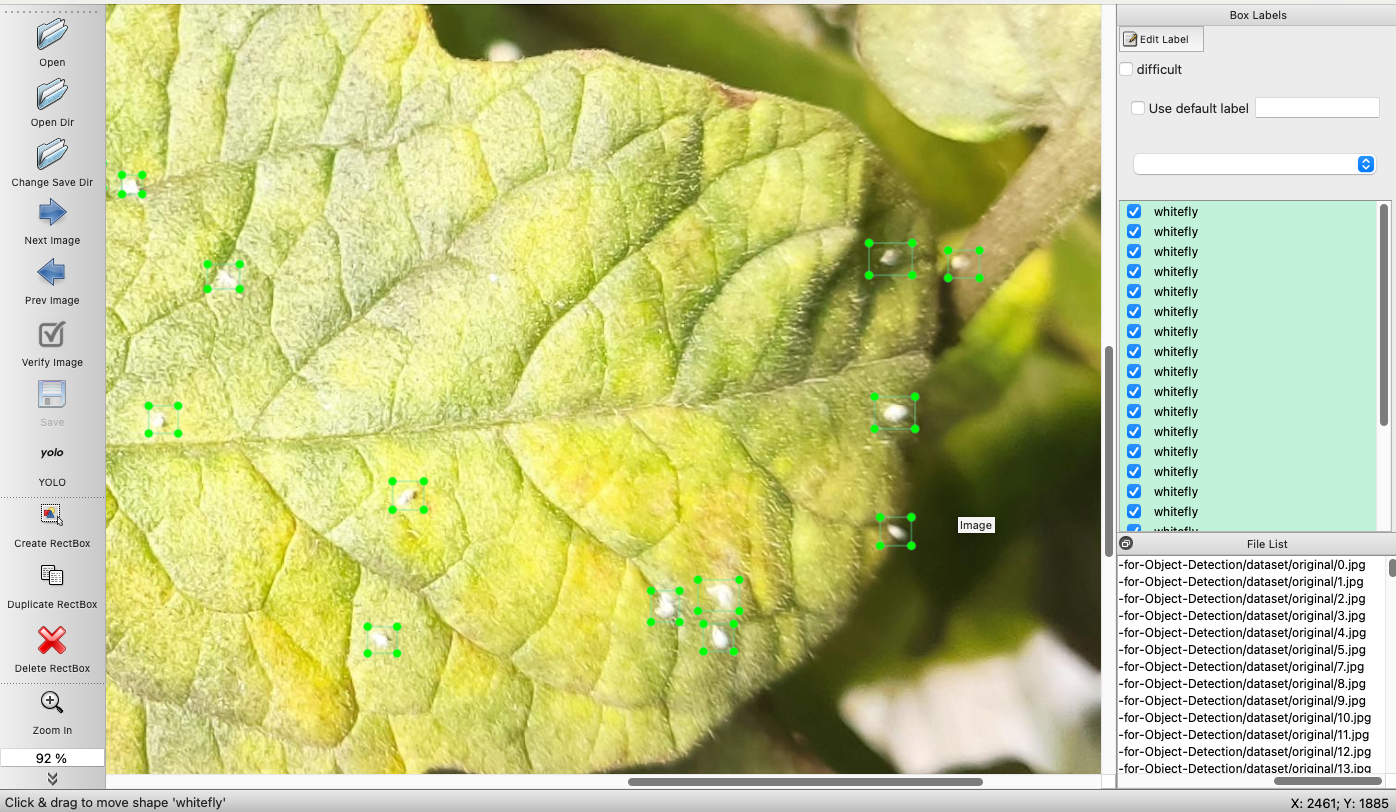

## Dataset Format for YOLO Training


To train a YOLO model, your dataset must follow a specific structure and include a `.yaml` configuration file that defines where your images and annotations are located, along with the list of classes.

---

### Folder Structure

Each image should have a corresponding `.txt` annotation file with the same name (e.g., `image1.jpg` ↔ `image1.txt`), and these should be placed in the appropriate subfolders.

```text
dataset/
├── train/
├── val/
├── test/
└── data.yaml
```

> **Note:** YOLO expects labels in `.txt` format where each line corresponds to one bounding box, with the format:
>
> ```
> <class_id> <x_center> <y_center> <width> <height>
> ```
> All values must be normalized (from 0 to 1) relative to image size.

---

### `data.yaml` Example

```yaml
train: dataset/train/images
val: dataset/val/images
test: dataset/test/images

nc: 1  # number of classes
names: ['WF'] #name of the class that MUST match the <class_id> in the annotation file
```

## Object Detection with YOLOv11


Once your dataset is prepared and organized correctly, you can begin training your YOLOv11 model. In this example, we’ll use the **medium version** of YOLOv11 (`yolov11m.pt`) and train on a custom dataset.


### Step 1: Dataset Splitting

We use a utility function to split the dataset into **training** and **validation** sets, assuming a separate **test set** already exists.

This example splits a dataset of 200 images into:
- **60% for training**
- **20% for validation**
- The remaining **20% are reserved as the test set**

In [4]:
from utils import get_split, split_dataset

# Get train/val split from dataset (test already fixed)
train, val = get_split(train_size=0.6, val_size=0.2, dataset_size=200)

# Save to dataset/run/train and dataset/run/val
split_dataset(train_split=train, val_split=val)
print("Train and validation splits saved successfully.")

Train and validation splits saved successfully.


### Step 2: Model Training

After the dataset splitting process, it is important to define the training parameters.

Some important parameters to define are: **image size**, number of **epochs**, how to initialize the model **weights**, and the **batch size**.

Let us clarify each of them:

**Image size** refers to the resolution to which every input image is resized before being fed into the yolov11 model. This fixed-size input is necessary because the model architecture (fully convolutional with final dense layers) expects inputs of the same size.

An **epoch** is one complete pass through the entire training dataset by the learning algorithm.



**Batch size** is the number of training samples processed before the model updates its weights.

For each batch:
- The model makes predictions.
- The loss is computed.
- The optimizer adjusts weights using gradients from that batch.

In [10]:
from utils import train_yolo

project = "training/example_yolov11n"

name = "yolov11n_custom"

# Train the YOLO model
train_yolo(
    img=608, # Image size
    epochs=20, # Number of epochs
    data="dataset/data.yaml", # Path to data configuration file
    weights="yolo11n.pt", # Pre-trained weights from COCO dataset
    batch=4, # Batch size
    name=name, # Name of the training run
    project=project # Project directory for saving results
)

Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=608, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_custom2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1732.7±341.1 MB/s, size: 788.4 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]

Plotting labels to example_training/yolov11n_custom2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_training/yolov11n_custom2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.759      3.898      0.989        289        608: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all         40       2266     0.0237      0.125     0.0142    0.00499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20         0G      2.522      2.367     0.9047        446        608: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

                   all         40       2266     0.0374      0.198     0.0234    0.00736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/20         0G      2.628      2.002     0.8816        543        608: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all         40       2266       0.56      0.227       0.24     0.0847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/20         0G      2.554      1.911     0.8919        304        608: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all         40       2266      0.485       0.28      0.251     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/20         0G      2.422      1.771     0.8799        165        608: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all         40       2266      0.564       0.31      0.323      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/20         0G      2.616      1.755     0.8906        150        608: 100%|██████████| 30/30 [00:31<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all         40       2266      0.561      0.331      0.342      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/20         0G      2.307      1.563     0.8607        238        608: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all         40       2266      0.596      0.355      0.367      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.386      1.571     0.8658        266        608: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all         40       2266      0.628      0.355      0.391      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/20         0G      2.293      1.598     0.8545        247        608: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2266      0.639      0.368      0.405      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/20         0G        2.3      1.508     0.8522        293        608: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all         40       2266      0.646      0.374       0.42      0.179
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/20         0G      2.094      1.502     0.8411        198        608: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all         40       2266      0.672      0.388       0.44      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/20         0G       2.18      1.569     0.8459        244        608: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all         40       2266      0.567      0.382      0.396      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/20         0G      2.136      1.517     0.8386        155        608: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all         40       2266      0.575      0.391      0.418      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/20         0G      2.112      1.506     0.8458        148        608: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all         40       2266      0.606      0.398      0.438      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/20         0G      2.133      1.498     0.8392        224        608: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2266      0.623      0.405      0.444      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/20         0G       2.09       1.46       0.83        247        608: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all         40       2266      0.644      0.411       0.45       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/20         0G      1.998      1.327     0.8314        235        608: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all         40       2266      0.649      0.421      0.467      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      2.027       1.37     0.8381        278        608: 100%|██████████| 30/30 [00:30<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2266      0.645       0.43      0.472       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/20         0G      1.926      1.306     0.8322        443        608: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all         40       2266      0.654       0.43      0.471      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/20         0G      1.851      1.311     0.8385        120        608: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all         40       2266      0.666      0.432      0.476       0.23

20 epochs completed in 0.195 hours.
Optimizer stripped from example_training/yolov11n_custom2/weights/last.pt, 5.5MB


Optimizer stripped from example_training/yolov11n_custom2/weights/best.pt, 5.5MB

Validating example_training/yolov11n_custom2/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


                   all         40       2266      0.665      0.432      0.476       0.23
Speed: 0.7ms preprocess, 40.3ms inference, 0.0ms loss, 9.7ms postprocess per image
Results saved to example_training/yolov11n_custom2


### Step 3: Detection with the Trained Model

Once your model has been trained, you can use it to detect objects in new images.

Below is an example of how to **load your trained YOLOv11 model**, run inference on a single image, and **visualize the results** using `OpenCV` and `matplotlib`.

In [15]:
from utils import detect_yolo

file_to_detect = 'examples/example_video.mp4' # Path to the video file to detect objects in
image_to_detect = 'dataset/improved/2.jpg' # Path to the image file to detect objects in

# Run detection using the trained YOLO model
results = detect_yolo(
    source=image_to_detect, # Source file for detection
    weights=f"{project}/{name}/weights/best.pt", # Path to the best weights
    img=608, # Image size for detection
)



image 1/1 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/improved/2.jpg: 608x608 17 WFs, 114.6ms
Speed: 9.7ms preprocess, 114.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 608)
Results saved to .temp/detect/detect
1 label saved to .temp/detect/detect/labels


## Active Learning Setup

In this section, we simulate an **Active Learning (AL)** strategy. The goal is to iteratively label and train on small batches of data, allowing the model to improve while reducing annotation costs.

---

###  Strategy

- We start with a small **initial labeled subset**
- Then, simulate **N rounds of Active Learning**, each adding a new batch of unlabeled data
- After each round, the model is re-trained on the growing labeled set

In [ ]:
from utils import get_split, split_dataset, new_batch, train_yolo, test_yolo
import pandas as pd

# Dataset setup
dataset_size = 200 # Total number of images in the dataset
num_batches = 10 # Number of batches to process
batch_train_prop = 0.6 / num_batches # Proportion of images in each batch for training
batch_val_prop = 0.2 / num_batches # Proportion of images in each batch for validation

num_epochs = 5 # Number of epochs for each training run

# Project base
project = "example_active_learning"
base_weights = "yolo11n.pt"

# Initialize results
results_df = pd.DataFrame(index=range(num_batches))

initial_train_split, initial_val_split = get_split(
                train_size=batch_train_prop,
                val_size=batch_val_prop,
                dataset_size=dataset_size
            ) 

# 🔁 Define a function to run a full mode (AL or random)
def run_training_loop(mode="al"):
    #weights = base_weights # Start with base weights

    for batch in range(num_batches):
        print(f"\n=== Batch {batch} / {num_batches} — Mode: {mode} ===")
        name = f"{mode}_batch_{batch}"

        if batch == 0:
            print("📦 Creating initial train/val split...")
            split_dataset(train_split=initial_train_split, val_split=initial_val_split)
        else:
            print(f"🎯 Selecting data for {mode}...")
            new_batch(
                random=(mode == "random"),
                al="confidence",
                weights=weights,
                train_images=int(batch_train_prop * dataset_size),
                val_images=int(batch_val_prop * dataset_size),
                project=f"{project}_{mode}/detecting",
                name=name,
                dataset="original",
                img_size=608
            )

        print(f"🏋️ Training model for {name} ...")
        results = train_yolo(
            img=608,
            epochs=num_epochs,
            data="dataset/data.yaml",
            weights=base_weights, # Use base weights for training (always start from scratch)
            batch=4,
            name=name,
            project=f"{project}_{mode}/training"
        )

        weights = f"{project}_{mode}/training/{name}/weights/best.pt" # Weights used to compute most relevant images in the next batch and for testing
        test_results = test_yolo(
            img=608,
            data="dataset/data.yaml",
            weights=weights,
            project=f"{project}_{mode}/testing"
        )
        mAP_test = float(test_results.results_dict["metrics/mAP50(B)"])
        mAP = float(results.results_dict["metrics/mAP50(B)"])
        #results_df.loc[batch, f"{mode}_mAP"] = mAP
        results_df.loc[batch, f"{mode} mAP (test)"] = mAP_test
        print(f"✅ Batch {batch + 1} ({mode}) done — mAP@50: {mAP:.4f}")

# Run both modes
run_training_loop(mode="al")
run_training_loop(mode="random")

# View combined results
display(results_df)
%matplotlib inline
results_df.plot(title="Active Learning vs Random Selection (mAP@50)", marker='o')


=== Batch 0 / 10 — Mode: al ===
📦 Creating initial train/val split...
🏋️ Training model for al_batch_0 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=608, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 2144.33it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3942.8±2586.7 MB/s, size: 752.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 2958.42it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_0/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_0
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.602      6.397      1.081        190        608: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      3.013      4.199      1.072        306        608: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G       2.65      4.046      1.015        327        608: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.446      4.047     0.9541        166        608: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.589      3.959     0.9886        304        608: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          4        163          0          0          0          0

5 epochs completed in 0.005 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_0/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_0/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_0/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


                   all          4        163          0          0          0          0
Speed: 0.4ms preprocess, 48.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_0
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1457.7±224.5 MB/s, size: 796.8 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


                   all         40       2060    0.00125    0.00728    0.00063   0.000281
Speed: 0.7ms preprocess, 98.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 1 (al) done — mAP@50: 0.0000

=== Batch 1 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 144
Detection directory created at: dataset/detect

image 1/144 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 49.7ms
image 2/144 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 45.9ms
image 3/144 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 608x608 (no detections), 53.4ms
image 4/144 /Users/ddcosta/Desktop/Ib

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 4010.01it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5017.5±3795.1 MB/s, size: 866.2 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 4115.59it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_1
Starting training for 5 epochs...



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       3.25      4.264      1.136        218        608: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all          8        356          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.726      3.967      1.038        227        608: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          8        356          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.714      3.827     0.9906        172        608: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          8        356    0.00167     0.0112   0.000845   0.000127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.675      3.511     0.9919        261        608: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          8        356    0.00833     0.0562    0.00447    0.00123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      2.749      3.422     0.9999        220        608: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          8        356     0.0117     0.0787    0.00649    0.00185

5 epochs completed in 0.010 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_1/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_1/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_1/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


                   all          8        356     0.0117     0.0787    0.00649    0.00185
Speed: 0.4ms preprocess, 38.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_1
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1874.2±295.6 MB/s, size: 804.3 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


                   all         40       2060     0.0136     0.0791    0.00763    0.00251
Speed: 0.6ms preprocess, 104.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 2 (al) done — mAP@50: 0.0065

=== Batch 2 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 128
Detection directory created at: dataset/detect

image 1/128 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 48.8ms
image 2/128 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 51.2ms
image 3/128 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 608x608 (no detections), 47.9ms
image 4/128 /Users/ddcosta/Desktop/I

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 36 images, 1 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 3351.35it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4142.3±3219.2 MB/s, size: 828.1 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 3629.86it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.142      4.519      1.078        233        608: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         12        594   0.000278    0.00168   0.000141   2.81e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.688      3.805      1.003        101        608: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         12        594     0.0025     0.0152    0.00127   0.000239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.712      3.398     0.9531        260        608: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         12        594     0.0139     0.0842    0.00777    0.00217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.588      3.033     0.9279        149        608: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         12        594     0.0233      0.141     0.0145    0.00385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.492      2.707     0.9321        139        608: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         12        594     0.0236      0.143     0.0151    0.00422

5 epochs completed in 0.014 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_2/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_2/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_2/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


                   all         12        594     0.0236      0.143     0.0151     0.0042
Speed: 0.4ms preprocess, 41.3ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_2
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1134.4±278.2 MB/s, size: 808.7 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


                   all         40       2060     0.0265      0.154     0.0169    0.00557
Speed: 0.7ms preprocess, 105.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 3 (al) done — mAP@50: 0.0151

=== Batch 3 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 112
Detection directory created at: dataset/detect

image 1/112 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 45.1ms
image 2/112 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 49.8ms
image 3/112 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 608x608 (no detections), 46.0ms
image 4/112 /Users/ddcosta/Desktop/I

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 48 images, 1 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 4056.06it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3014.7±2013.1 MB/s, size: 806.9 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 1214.22it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       3.21      4.664      1.105        231        608: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         16        802   0.000208    0.00125   0.000106   6.34e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.796      3.779       1.02        169        608: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         16        802    0.00729     0.0436    0.00386    0.00109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.709      3.128     0.9382        276        608: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         16        802      0.015     0.0898    0.00851    0.00226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.619      2.641     0.9289        209        608: 100%|██████████| 12/12 [00:12<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         16        802     0.0192      0.115     0.0113     0.0027

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.478      2.356     0.9234        348        608: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         16        802     0.0288      0.172     0.0187    0.00496

5 epochs completed in 0.020 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_3/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_3/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_3/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


                   all         16        802     0.0288      0.172     0.0187    0.00497
Speed: 0.4ms preprocess, 38.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_3
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1119.8±161.7 MB/s, size: 632.5 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


                   all         40       2060      0.024       0.14     0.0148    0.00453
Speed: 0.7ms preprocess, 101.9ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 4 (al) done — mAP@50: 0.0187

=== Batch 4 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 96
Detection directory created at: dataset/detect

image 1/96 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 46.6ms
image 2/96 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 50.3ms
image 3/96 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/10.jpg: 608x608 (no detections), 45.9ms
image 4/96 /Users/ddcosta/Desktop/IbPRIA

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 60 images, 1 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 4294.29it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2771.7±1980.0 MB/s, size: 771.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 4051.10it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.328      5.038      1.116        153        608: 100%|██████████| 15/15 [00:15<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         20        918   0.000167    0.00109   8.37e-05   1.67e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.761      3.593      0.985        268        608: 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         20        918     0.0117     0.0763    0.00656    0.00191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.627      2.865     0.9365        179        608: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         20        918     0.0173      0.113     0.0102    0.00242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.538      2.456     0.9137        481        608: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         20        918     0.0205      0.134     0.0127    0.00378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.594      2.246       0.92        244        608: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         20        918     0.0323      0.211     0.0386     0.0118

5 epochs completed in 0.025 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_4/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_4/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_4/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


                   all         20        918     0.0323      0.211     0.0386     0.0118
Speed: 0.4ms preprocess, 41.2ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_4
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1329.9±178.6 MB/s, size: 918.3 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


                   all         40       2060     0.0367      0.214     0.0645      0.024
Speed: 0.7ms preprocess, 102.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 5 (al) done — mAP@50: 0.0386

=== Batch 5 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 80
Detection directory created at: dataset/detect

image 1/80 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 44.2ms
image 2/80 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 43.0ms
image 3/80 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/118.jpg: 608x608 (no detections), 43.2ms
image 4/80 /Users/ddcosta/Desktop/IbPRI

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 72 images, 1 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<00:00, 4542.29it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1997.4±343.6 MB/s, size: 735.9 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 4564.19it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_5/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.374      4.667      1.136        297        608: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         24       1101    0.00167     0.0109   0.000848   0.000225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.682      3.167     0.9749        223        608: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         24       1101     0.0151      0.099    0.00932    0.00247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.635      2.503     0.9366        152        608: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         24       1101     0.0182      0.119     0.0108    0.00268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.746      2.279     0.9305        239        608: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         24       1101     0.0389      0.254     0.0546     0.0167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.572      2.094     0.9119        269        608: 100%|██████████| 18/18 [00:20<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         24       1101     0.0496      0.324      0.136     0.0445

5 epochs completed in 0.031 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_5/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_5/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_5/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


                   all         24       1101     0.0497      0.325      0.136     0.0444
Speed: 0.4ms preprocess, 38.5ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_5
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1496.9±299.6 MB/s, size: 737.0 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


                   all         40       2060     0.0584       0.34      0.174     0.0694
Speed: 0.4ms preprocess, 102.5ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 6 (al) done — mAP@50: 0.1361

=== Batch 6 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 64
Detection directory created at: dataset/detect

image 1/64 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 45.5ms
image 2/64 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 43.6ms
image 3/64 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/140.jpg: 608x608 (no detections), 44.2ms
image 4/64 /Users/ddcosta/Desktop/IbPRI

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 84 images, 1 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 4714.34it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4257.4±4471.5 MB/s, size: 932.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 5008.98it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_6/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.221      4.898       1.11        171        608: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all         28       1332     0.0019      0.012   0.000965   0.000276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      2.703      3.027     0.9557        171        608: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all         28       1332     0.0194      0.122     0.0118    0.00303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G       2.96      2.452     0.9351        224        608: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all         28       1332     0.0201      0.127     0.0121     0.0038

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.712      2.149     0.9112        265        608: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all         28       1332     0.0412       0.26     0.0332     0.0105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.642       2.12     0.9134        174        608: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all         28       1332       0.39      0.237      0.204     0.0628

5 epochs completed in 0.036 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_6/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_6/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_6/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


                   all         28       1332       0.39      0.236      0.204     0.0625
Speed: 0.4ms preprocess, 41.9ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_6
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1409.0±205.6 MB/s, size: 854.0 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


                   all         40       2060      0.517       0.24      0.254     0.0943
Speed: 0.8ms preprocess, 105.1ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 7 (al) done — mAP@50: 0.2036

=== Batch 7 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 48
Detection directory created at: dataset/detect

image 1/48 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 50.7ms
image 2/48 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 49.1ms
image 3/48 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/140.jpg: 608x608 (no detections), 46.2ms
image 4/48 /Users/ddcosta/Desktop/IbPRI

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 96 images, 1 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 4019.90it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3320.9±3554.7 MB/s, size: 717.2 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 3915.34it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.969      4.105      1.068        130        608: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all         32       1500     0.0146     0.0933    0.00812     0.0024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.678      2.649     0.9351        290        608: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all         32       1500     0.0232      0.149     0.0142    0.00328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.689      2.307     0.9348        301        608: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all         32       1500     0.0505      0.323     0.0751     0.0229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.609      2.096     0.9247        269        608: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all         32       1500     0.0633      0.405      0.209     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G        2.5      1.858     0.9159        246        608: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all         32       1500      0.576        0.2      0.262     0.0801

5 epochs completed in 0.040 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_7/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_7/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_7/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


                   all         32       1500      0.577      0.201      0.261     0.0799
Speed: 0.4ms preprocess, 39.1ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_7
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1133.5±204.3 MB/s, size: 749.2 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


                   all         40       2060      0.722      0.215      0.307      0.106
Speed: 0.7ms preprocess, 100.3ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 8 (al) done — mAP@50: 0.2613

=== Batch 8 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 32
Detection directory created at: dataset/detect

image 1/32 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 45.9ms
image 2/32 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/1.jpg: 608x608 (no detections), 48.4ms
image 3/32 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/144.jpg: 608x608 2 WFs, 43.3ms
image 4/32 /Users/ddcosta/Desktop/IbPRIA2015---Da

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 108 images, 1 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<00:00, 4694.78it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4041.1±2925.0 MB/s, size: 892.4 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 4481.49it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_8/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.985      4.017      1.041        234        608: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all         36       1908     0.0105     0.0592    0.00572    0.00166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.799      2.607     0.9417        203        608: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all         36       1908     0.0249      0.141     0.0157    0.00452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.725      2.224     0.9247        325        608: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all         36       1908     0.0453      0.256     0.0525     0.0165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.673      2.053     0.9236        249        608: 100%|██████████| 27/27 [00:29<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all         36       1908       0.43       0.23      0.207     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.619      1.962      0.909        178        608: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all         36       1908      0.518      0.242      0.247     0.0776

5 epochs completed in 0.044 hours.
Optimizer stripped from example_active_learning_al/training/al_batch_8/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_al/training/al_batch_8/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_8/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


                   all         36       1908      0.517      0.242      0.247     0.0776
Speed: 0.5ms preprocess, 39.7ms inference, 0.0ms loss, 9.7ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_8
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1392.6±318.8 MB/s, size: 735.6 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


                   all         40       2060       0.65      0.308      0.344      0.122
Speed: 0.5ms preprocess, 105.2ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 9 (al) done — mAP@50: 0.2472

=== Batch 9 / 10 — Mode: al ===
🎯 Selecting data for al...
Creating new batch with 12 train images and 4 validation images.
Using active learning mode: confidence
Available indices for new batch: 16
Detection directory created at: dataset/detect

image 1/16 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/0.jpg: 608x608 (no detections), 47.8ms
image 2/16 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/144.jpg: 608x608 10 WFs, 44.5ms
image 3/16 /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/detect/146.jpg: 608x608 9 WFs, 48.9ms
image 4/16 /Users/ddcosta/Desktop/IbPRIA2015---Data-Effi

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 120 images, 1 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 4365.54it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2781.7±2482.8 MB/s, size: 778.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 4699.24it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_al/training/al_batch_9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_al/training/al_batch_9
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.043      3.947      1.043        369        608: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all         40       2104     0.0209      0.119     0.0131    0.00343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.587      2.348     0.9306        312        608: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2104      0.039      0.222     0.0265    0.00959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.744      2.144     0.9095        407        608: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2104     0.0586      0.334      0.142      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.747      2.138     0.9272        258        608: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all         40       2104       0.57      0.184      0.229     0.0742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.578      1.916     0.9077        149        608: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all         40       2104      0.509      0.268      0.274     0.0932

5 epochs completed in 0.050 hours.


Optimizer stripped from example_active_learning_al/training/al_batch_9/weights/last.pt, 5.5MB
Optimizer stripped from example_active_learning_al/training/al_batch_9/weights/best.pt, 5.5MB

Validating example_active_learning_al/training/al_batch_9/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


                   all         40       2104      0.509      0.268      0.274     0.0933
Speed: 0.4ms preprocess, 40.0ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to example_active_learning_al/training/al_batch_9
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1358.4±256.8 MB/s, size: 728.5 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


                   all         40       2060      0.642      0.335      0.373       0.16
Speed: 0.7ms preprocess, 105.0ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to example_active_learning_al/testing/test
✅ Batch 10 (al) done — mAP@50: 0.2735

=== Batch 0 / 10 — Mode: random ===
📦 Creating initial train/val split...
🏋️ Training model for random_batch_0 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, form

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 3579.01it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9440.7±2425.2 MB/s, size: 752.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 4377.05it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_0
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        1/5         0G      3.602      6.397      1.081        190        608: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      3.013      4.199      1.072        306        608: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G       2.65      4.046      1.015        327        608: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.446      4.047     0.9541        166        608: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          4        163          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.589      3.959     0.9886        304        608: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all          4        163          0          0          0          0

5 epochs completed in 0.005 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_0/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_0/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_0/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


                   all          4        163          0          0          0          0
Speed: 0.4ms preprocess, 48.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_0
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1374.0±260.0 MB/s, size: 796.8 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


                   all         40       2060    0.00125    0.00728    0.00063   0.000281
Speed: 0.7ms preprocess, 99.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 1 (random) done — mAP@50: 0.0000

=== Batch 1 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 144
🏋️ Training model for random_batch_1 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropou

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 3946.81it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7493.0±1734.4 MB/s, size: 777.5 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 5141.65it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        1/5         0G      3.255      4.339      1.159        309        608: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          8        356          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.828      3.991      1.057        310        608: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all          8        356          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.921      3.838      1.051        158        608: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          8        356   0.000417    0.00281   0.000211   4.23e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      3.117      3.696       1.05        266        608: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          8        356     0.0025     0.0169    0.00128   0.000254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      2.554      3.385      0.983        320        608: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          8        356    0.00542     0.0365    0.00289   0.000746

5 epochs completed in 0.010 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_1/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_1/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_1/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


                   all          8        356    0.00542     0.0365    0.00289   0.000746
Speed: 0.4ms preprocess, 36.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_1
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1298.5±587.1 MB/s, size: 804.3 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


                   all         40       2060    0.00842      0.049    0.00454    0.00149
Speed: 0.5ms preprocess, 102.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 2 (random) done — mAP@50: 0.0029

=== Batch 2 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 128
🏋️ Training model for random_batch_2 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropo

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 36 images, 1 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 3590.33it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7817.3±818.4 MB/s, size: 750.5 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 4330.72it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       3.43      4.708      1.145        301        608: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         12        586          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.881      4.003      1.007        227        608: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         12        586    0.00167     0.0102   0.000844   0.000252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G       2.83      3.531     0.9908        151        608: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         12        586    0.00667      0.041    0.00357    0.00114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.682      3.175      0.969        198        608: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         12        586     0.0139     0.0853    0.00785    0.00234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.507      2.832     0.9188        290        608: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         12        586     0.0153     0.0939    0.00895    0.00252

5 epochs completed in 0.015 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_2/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_2/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_2/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


                   all         12        586     0.0153     0.0939    0.00895    0.00254
Speed: 0.4ms preprocess, 44.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_2
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1329.6±353.8 MB/s, size: 808.7 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


                   all         40       2060     0.0227      0.133     0.0138    0.00446
Speed: 0.8ms preprocess, 103.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 3 (random) done — mAP@50: 0.0089

=== Batch 3 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 112
🏋️ Training model for random_batch_3 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropo

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 48 images, 1 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 4419.61it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11342.6±1544.1 MB/s, size: 872.3 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 5742.67it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        1/5         0G      3.328      4.937      1.133        432        608: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         16        684   0.000625    0.00439   0.000317   4.22e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.981      3.663      1.079        281        608: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         16        684     0.0104     0.0731    0.00596    0.00168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.678       3.06     0.9548        321        608: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         16        684     0.0206      0.145     0.0146    0.00402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      2.662      2.639     0.9527        291        608: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         16        684     0.0217      0.152     0.0158    0.00417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G       2.63      2.424     0.9282        301        608: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         16        684     0.0229      0.161      0.016    0.00422

5 epochs completed in 0.021 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_3/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_3/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_3/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


                   all         16        684     0.0229      0.161      0.016    0.00422
Speed: 0.4ms preprocess, 41.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_3
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1066.1±100.6 MB/s, size: 632.5 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


                   all         40       2060      0.032      0.186     0.0276     0.0109
Speed: 0.7ms preprocess, 107.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 4 (random) done — mAP@50: 0.0160

=== Batch 4 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 96
🏋️ Training model for random_batch_4 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropou

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 60 images, 1 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 3955.65it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8760.8±3035.3 MB/s, size: 868.1 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 4571.45it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.956      4.084      1.076        186        608: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         20        860     0.0005    0.00349   0.000251   5.04e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.907      3.345      1.006        244        608: 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         20        860     0.0192      0.134     0.0116    0.00264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.731      2.642     0.9553        196        608: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         20        860      0.025      0.174     0.0164    0.00383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      2.661      2.319     0.9054        222        608: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         20        860      0.025      0.174     0.0269    0.00697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.682      2.197     0.9231        235        608: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         20        860      0.036      0.251      0.064     0.0186

5 epochs completed in 0.026 hours.


Optimizer stripped from example_active_learning_random/training/random_batch_4/weights/last.pt, 5.5MB
Optimizer stripped from example_active_learning_random/training/random_batch_4/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_4/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


                   all         20        860      0.036      0.251     0.0622     0.0181
Speed: 0.4ms preprocess, 42.1ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_4
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1441.5±219.2 MB/s, size: 918.3 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


                   all         40       2060     0.0438      0.255     0.0792     0.0247
Speed: 0.7ms preprocess, 102.1ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 5 (random) done — mAP@50: 0.0622

=== Batch 5 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 80
🏋️ Training model for random_batch_5 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropou

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 72 images, 1 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<00:00, 4669.49it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8734.3±1566.6 MB/s, size: 673.9 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 4764.68it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_5
Starting training for 5 epochs...



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.161      4.365      1.088        325        608: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         24       1112    0.00222     0.0144    0.00119   0.000359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.672      3.104     0.9483        239        608: 100%|██████████| 18/18 [00:20<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         24       1112    0.00806     0.0522    0.00429    0.00114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.596      2.403     0.9233        103        608: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         24       1112    0.00917     0.0594     0.0049    0.00132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.661      2.188     0.9285        197        608: 100%|██████████| 18/18 [00:20<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         24       1112     0.0217       0.14     0.0266    0.00669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.645      2.064       0.92        218        608: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         24       1112     0.0357      0.231      0.072     0.0223

5 epochs completed in 0.031 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_5/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_5/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_5/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


                   all         24       1112     0.0356       0.23      0.072     0.0223
Speed: 0.5ms preprocess, 36.9ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_5
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1459.5±372.4 MB/s, size: 737.0 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


                   all         40       2060      0.045      0.262      0.101     0.0341
Speed: 0.6ms preprocess, 105.6ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 6 (random) done — mAP@50: 0.0720

=== Batch 6 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 64
🏋️ Training model for random_batch_6 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropou

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 84 images, 1 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 2949.65it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7210.2±3526.1 MB/s, size: 816.2 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 4132.46it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_6/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.055      4.284      1.091        256        608: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all         28       1252    0.00119    0.00799    0.00107   0.000279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.484      2.868     0.9333        340        608: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all         28       1252     0.0025     0.0168    0.00127   0.000368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.616      2.212     0.9135        239        608: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all         28       1252    0.00702     0.0471     0.0038     0.0013

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.654       2.09     0.9081        358        608: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all         28       1252     0.0252      0.169     0.0339     0.0124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.542          2     0.9164        205        608: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all         28       1252      0.694      0.153       0.24     0.0823

5 epochs completed in 0.035 hours.
Optimizer stripped from example_active_learning_random/training/random_batch_6/weights/last.pt, 5.5MB


Optimizer stripped from example_active_learning_random/training/random_batch_6/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_6/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all         28       1252      0.693      0.153       0.24      0.082
Speed: 0.5ms preprocess, 41.7ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_6
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1399.0±334.3 MB/s, size: 854.0 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


                   all         40       2060      0.809      0.167      0.281      0.125
Speed: 0.7ms preprocess, 103.0ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 7 (random) done — mAP@50: 0.2399

=== Batch 7 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 48
🏋️ Training model for random_batch_7 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropou

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 96 images, 1 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 3680.16it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5248.5±2146.8 MB/s, size: 919.7 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 2612.46it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.058      4.523      1.049        140        608: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all         32       1814    0.00281     0.0149    0.00144   0.000412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.662       2.72     0.9346        218        608: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all         32       1814   0.000937    0.00496   0.000472   9.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.704      2.247     0.9163        320        608: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all         32       1814     0.0306      0.162     0.0376     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.641      1.947     0.9182        372        608: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all         32       1814     0.0491       0.26      0.131     0.0461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.568      2.059     0.9167        208        608: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all         32       1814      0.569        0.2      0.208     0.0711

5 epochs completed in 0.041 hours.


Optimizer stripped from example_active_learning_random/training/random_batch_7/weights/last.pt, 5.5MB
Optimizer stripped from example_active_learning_random/training/random_batch_7/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_7/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


                   all         32       1814       0.57        0.2      0.208     0.0711
Speed: 0.4ms preprocess, 40.7ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_7
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1392.6±257.7 MB/s, size: 749.2 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


                   all         40       2060      0.714      0.281      0.344      0.133
Speed: 0.6ms preprocess, 103.9ms inference, 0.0ms loss, 10.3ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 8 (random) done — mAP@50: 0.2081

=== Batch 8 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 32
🏋️ Training model for random_batch_8 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropo

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 108 images, 1 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<00:00, 3312.96it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4021.1±2919.0 MB/s, size: 845.1 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 4146.50it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_8/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.975       4.22      1.079        191        608: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all         36       1934    0.00537       0.03    0.00281   0.000797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.721      2.642     0.9585        182        608: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all         36       1934     0.0207      0.116     0.0123    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.717      2.187     0.9269        284        608: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         36       1934     0.0426      0.238     0.0519     0.0174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.605      2.012     0.9205        320        608: 100%|██████████| 27/27 [00:30<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all         36       1934      0.421      0.226      0.202     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.563      1.889     0.9076        267        608: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all         36       1934       0.49      0.239      0.228     0.0761

5 epochs completed in 0.046 hours.


Optimizer stripped from example_active_learning_random/training/random_batch_8/weights/last.pt, 5.5MB
Optimizer stripped from example_active_learning_random/training/random_batch_8/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_8/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


                   all         36       1934      0.492       0.24      0.229     0.0762
Speed: 0.4ms preprocess, 44.0ms inference, 0.0ms loss, 12.5ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_8
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1175.6±217.6 MB/s, size: 735.6 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


                   all         40       2060      0.642      0.319      0.357       0.14
Speed: 1.0ms preprocess, 104.3ms inference, 0.0ms loss, 11.3ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 9 (random) done — mAP@50: 0.2292

=== Batch 9 / 10 — Mode: random ===
🎯 Selecting data for random...
Creating new batch with 12 train images and 4 validation images.
Available indices for new batch: 16
🏋️ Training model for random_batch_9 ...
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropo

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 120 images, 1 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 4620.76it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5366.4±3482.6 MB/s, size: 779.2 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 4420.29it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache
Plotting labels to example_active_learning_random/training/random_batch_9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_active_learning_random/training/random_batch_9
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.921      3.776      1.023        235        608: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all         40       2169    0.00658     0.0364    0.00345    0.00099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.663      2.317     0.9403        213        608: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all         40       2169     0.0218      0.121     0.0185    0.00626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.734      2.113     0.9262        464        608: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all         40       2169     0.0503      0.278      0.119     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      2.705      2.062     0.9215        175        608: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all         40       2169      0.504      0.217      0.217     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      2.675      1.947     0.9275        277        608: 100%|██████████| 30/30 [00:31<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

                   all         40       2169      0.485       0.26      0.241     0.0791

5 epochs completed in 0.051 hours.


Optimizer stripped from example_active_learning_random/training/random_batch_9/weights/last.pt, 5.5MB
Optimizer stripped from example_active_learning_random/training/random_batch_9/weights/best.pt, 5.5MB

Validating example_active_learning_random/training/random_batch_9/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


                   all         40       2169      0.484       0.26      0.241     0.0794
Speed: 0.4ms preprocess, 40.1ms inference, 0.0ms loss, 10.6ms postprocess per image
Results saved to example_active_learning_random/training/random_batch_9
Ultralytics 8.3.159 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1267.1±282.5 MB/s, size: 728.5 KB)


val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


                   all         40       2060      0.618      0.343      0.375      0.151
Speed: 0.7ms preprocess, 101.8ms inference, 0.0ms loss, 9.7ms postprocess per image
Results saved to example_active_learning_random/testing/test
✅ Batch 10 (random) done — mAP@50: 0.2414


,al mAP (test),random mAP (test)
0,0.000630,0.000630
1,0.007629,0.004544
2,0.016864,0.013780
3,0.014806,0.027647
4,0.064453,0.079249
5,0.174084,0.101269
6,0.254172,0.281070
7,0.307172,0.344027
8,0.343512,0.357115
9,0.373019,0.375195


## Data Quality

In object detection, **annotation quality** plays a critical role in model performance.

Unlike classification tasks, object detection requires:
- The correct **label** for each object
- A precise **bounding box** tightly enclosing the object


### Common Annotation Issues

- **Incorrect Labels**: The object is mislabeled or assigned the wrong class.
- **Poor Bounding Boxes**:
  - Boxes do not align with the object
  - Boxes are too loose or too tight
  - Boxes include multiple objects
- **Inconsistent Annotations** across similar samples

Such errors often stem from:
- **Repetitive labeling** tasks
- **Fatigue** or insufficient training of annotators

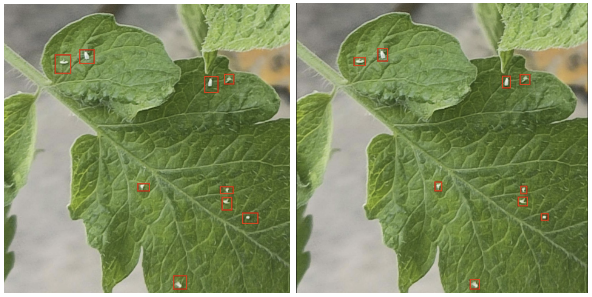

### Annotation Quality Example: Original vs Improved Labels

As an illustration of the importance of annotation quality, this notebook includes **two versions of the same dataset**:

- `dataset/original/`: Contains the original annotations
- `dataset/improved/`: Contains refined, higher-quality annotations

Both versions share the **same images**, but differ in the accuracy and consistency of their bounding boxes and labels.

#### Why Compare Them?

This allows us to analyze:
- How labeling precision impacts training performance
- Whether better annotations lead to **higher mAP** and more reliable predictions

By training the same model on each version, we can measure how much improvement is achieved **purely through better annotations** — without changing the model architecture or training strategy.

> This is especially useful in real-world projects, where annotation time is expensive, and correcting label errors can be more effective than adding more data.

In [ ]:
from utils import get_split, split_dataset, train_yolo, test_yolo
from IPython.display import clear_output
from IPython.display import display, Markdown

def train_and_test_yolo(name):
    # Train and test YOLO model with original annotations
    train_yolo(
        img=608,
        epochs=5,
        data="dataset/data.yaml",
        weights="yolo11n.pt",
        batch=4,
        name=name,
        project="example_data_quality/train"
    )
    
    map_results = test_yolo(
        img=608,
        data="dataset/data.yaml",
        weights=f"example_data_quality/train/{name}/weights/best.pt",
        project="example_data_quality/test"
    )
    
    return float(map_results.results_dict["metrics/mAP50(B)"])

# Get train/val split from dataset (test already fixed)
train_split, val_split = get_split(
    train_size=0.6,
    val_size=0.2,
    dataset_size=200
)

split_dataset(train_split=train_split, val_split=val_split, dataset="original") # Preparing the dataset with the original annotaions

map_original = train_and_test_yolo("original") # Train and test the model with original annotations

#----------

split_dataset(train_split=train_split, val_split=val_split, dataset="improved") # Preparing the dataset with the improved annotaions

map_improved = train_and_test_yolo("improved") # Train and test the model with improved annotations

clear_output(wait=True)

display(Markdown(f"""
---
### **Annotation Quality Comparison**

- <span style="color:crimson"><b>mAP with original annotations:</b></span> <code>{map_original:.4f}</code>
- <span style="color:seagreen"><b>mAP with improved annotations:</b></span> <code>{map_improved:.4f}</code>

**Absolute improvement:** <b style="color:royalblue">{improvement:.4f} mAP@50</b>  
**Relative improvement:** <b style="color:royalblue">{percent_improvement:.2f}%</b>
"""))


mAP with original annotations: 0.4480
mAP with improved annotations: 0.4535
Absolute improvement: 0.0055 mAP@50
Relative improvement: 1.23%


## Transfer Learning

Training object detection models from scratch can be time-consuming and data-hungry. To overcome this, we use **Transfer Learning (TL)** — a technique that leverages a model pre-trained on a large dataset (e.g., COCO) and adapts it to our custom task.



### Why Use Transfer Learning?

- **Jump-start training** with already-learned features
- **Reduce training time**
- **Improve performance**, especially when labeled data is limited

### Reusing a YOLOv5 Model

In this tutorial, we leverage **Transfer Learning** by starting from a pre-trained **YOLOv5** model trained to detect **whiteflies in yellow sticky traps**:

`pre-trained/yellow_trap.pt`

Although the original model was trained on the **same task** (whitefly detection), it was collected in a **different environment**. This makes it an excellent candidate for fine-tuning on our custom data.

#### 🔧 What Can Change During Fine-Tuning?

- The model’s **detection head** (final layers) is updated to match the number of classes in our current dataset.
- During training, the model retains the **general visual features** it has already learned (e.g., shapes, textures), while adapting to our specific setting.

> Transfer Learning helps us build accurate models faster, even with relatively small datasets — by reusing knowledge from related tasks.

In [3]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.59 MiB | 4.11 MiB/s, done.
Resolving deltas: 100% (11993/11993), done.


In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [4]:
!python yolov5/train.py \
    --cache ram --batch 4 --epochs 5 --img 608 \
    --data "yolov5/data.yaml" \
    --name "test" \
    --project "testv5" \
    --cfg "yolov5/models/yolov5s.yaml"  
    ##--weights ''#pre-trained/yellow_trap.pt 

/Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/yolov5/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=yolov5/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=4, imgsz=608, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population

In [3]:
from utils import get_split, split_dataset, train_yolo, test_yolo, train_yolov5, test_yolov5
from IPython.display import clear_output, display, Markdown

# # Get train/val split from dataset (test already fixed)
# train_split, val_split = get_split(
#     train_size=0.6,
#     val_size=0.2,
#     dataset_size=200
# )

# split_dataset(train_split=train_split, val_split=val_split, dataset="improved")

# train_results_transfer = train_yolov5(
#     img=608,
#     epochs=5,
#     data="dataset/data.yaml",
#     weights="pre-trained/yellow_trap.pt",  # Using YOLOv5 small as the pre-trained model
#     batch=4,
#     name="transfer",
#     project="example_transfer_learning/train"
# )
# test_results_transfer = test_yolov5(
#     img=608,
#     data="dataset/data.yaml",
#     weights=f"example_transfer_learning/train/transfer/weights/best.pt",
#     project="example_transfer_learning/test"
# )
# mAP_transfer = float(test_results_transfer.results_dict["metrics/mAP50(B)"])

train_results_baseline = train_yolo(
    img=608,
    epochs=5,
    data="dataset/data.yaml",
    weights="yolo11n.pt",
    batch=4,
    name="baseline",
    project="example_transfer_learning/train"
)

test_results_baseline = test_yolo(
    img=608,
    data="dataset/data.yaml",
    weights=f"example_transfer_learning/train/baseline/weights/best.pt",
    project="example_transfer_learning/test"
)
mAP_baseline = float(test_results_baseline.results_dict["metrics/mAP50(B)"])


clear_output(wait=True)  
print("Transfer Learning Results:")
display(Markdown(f"""
---### **Transfer Learning Comparison**
- <span style="color:crimson"><b>mAP with transfer learning:</b></span> <code>{mAP_transfer:.4f}</code>
- <span style="color:seagreen"><b>mAP with baseline YOLOv11n:</b></span> <code>{mAP_baseline:.4f}</code>    
**Absolute improvement:** <b style="color:royalblue">{mAP_transfer - mAP_baseline:.4f} mAP@50</b>  
**Relative improvement:** <b style="color:royalblue">{(mAP_transfer - mAP_baseline) / mAP_baseline * 100:.2f}%</b>
"""))    

/Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Ultralytics 8.3.160 🚀 Python-3.9.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=608, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, projec

train: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 3149.61it/s]

train: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1322.0±340.6 MB/s, size: 903.3 KB)



val: Scanning /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 4466.18it/s]

val: New cache created: /Users/ddcosta/Desktop/IbPRIA2015---Data-Efficient-Strategies-for-Object-Detection/dataset/run/val.cache


Plotting labels to example_transfer_learning/train/baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to example_transfer_learning/train/baseline
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       2.79      3.841      1.002        280        608: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

                   all         40       2439     0.0165     0.0812    0.00934    0.00277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.532      2.385     0.9001        514        608: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all         40       2439     0.0345       0.17     0.0275     0.0078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      2.494      2.047     0.8748        191        608:  67%|██████▋   | 20/30 [00:25<00:12,  1.26s/it]


KeyboardInterrupt: 